## V7: Корреляционный анализ по установкам (per-installation)

Цель: считать и визуализировать корреляции только по выбранной установке (`installation`) для заданного списка параметров.

Как использовать:
1) В ячейке с параметрами укажите `installation_name` и `params`.
2) Запустите ячейку — сохранится CSV и PNG только для этой установки.
3) Опционально: используйте батч-ячейку для списка установок; будет создано резюме.


In [1]:
# Импорты и настройки
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

if '../src' not in sys.path:
    sys.path.append('../src')
from database import load_corrosion_data

plt.style.use('default')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)

DATA_OUT_DIR = '../data/per_installation'
os.makedirs(DATA_OUT_DIR, exist_ok=True)

print('Библиотеки загружены, выходной каталог:', DATA_OUT_DIR)


Библиотеки загружены, выходной каталог: ../data/per_installation


In [2]:
# Загрузка и базовая очистка данных
print('Загружаю данные...')
df = load_corrosion_data()
print(f"Всего записей: {len(df):,}")

TARGET = 'corrosion_rate'
assert TARGET in df.columns

# Базовая фильтрация цели
before = len(df)
df = df[df[TARGET].notna()]
df = df[(df[TARGET] >= 0) & (df[TARGET] <= 10)]
print(f"После фильтрации по цели: {len(df):,} из {before:,}")

# Определим химические колонки
chem_cols = [c for c in df.columns if c.endswith('_content') or c.startswith('total_')]
for c in chem_cols:
    df[c] = df[c].fillna(0)

print('Готово. Химические параметры импутированы нулями.')


Загружаю данные...
Всего записей: 442,052
После фильтрации по цели: 313,132 из 442,052


C:\Users\admin\AppData\Local\Temp\ipykernel_18820\3640915608.py:18: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[c] = df[c].fillna(0)


Готово. Химические параметры импутированы нулями.


In [3]:
# Вспомогательные функции: подготовка и визуализация
from typing import List, Optional, Dict


def _sanitize_filename(name: str) -> str:
    s = ''.join(ch if ch.isalnum() else '_' for ch in str(name))
    while '__' in s:
        s = s.replace('__', '_')
    return s.strip('_') or 'installation'


def prepare_subset_for_corr(df_in: pd.DataFrame,
                            params: List[str],
                            target: str = TARGET) -> pd.DataFrame:
    cols = [c for c in [target] + params if c in df_in.columns]
    if target not in cols:
        raise ValueError(f"Колонка цели '{target}' отсутствует в данных")
    sub = df_in[cols].copy()
    # Импутация: химия/агрегаты -> 0, прочее -> медиана
    for c in cols:
        if c == target:
            continue
        if c.endswith('_content') or c.startswith('total_'):
            sub[c] = sub[c].fillna(0)
        else:
            sub[c] = sub[c].fillna(sub[c].median())
    return sub


def plot_corr_heatmap(corr: pd.DataFrame, title: str, save_path: Optional[str] = None):
    plt.figure(figsize=(max(10, 0.6 * corr.shape[0]), max(8, 0.6 * corr.shape[1])))
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, annot=True, cmap='RdBu_r', center=0, fmt='.2f',
                square=True, cbar_kws={'shrink': 0.8})
    plt.title(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150)
    plt.show()


def analyze_installation(df_in: pd.DataFrame,
                         installation_name: str,
                         params: List[str],
                         target: str = TARGET,
                         out_dir: str = DATA_OUT_DIR,
                         plot: bool = True) -> Optional[Dict]:
    if 'installation' not in df_in.columns:
        raise ValueError("В данных нет колонки 'installation'")

    dfi = df_in[df_in['installation'].astype(str) == str(installation_name)].copy()
    if len(dfi) == 0:
        print(f"Нет данных для installation='{installation_name}'")
        return None

    # Повторная безопасная фильтрация цели
    dfi = dfi[dfi[target].notna()]
    dfi = dfi[(dfi[target] >= 0) & (dfi[target] <= 10)]
    if len(dfi) == 0:
        print(f"После фильтрации нет данных для '{installation_name}'")
        return None

    params_present = [p for p in params if p in dfi.columns]
    if not params_present:
        print("Ни один из указанных параметров не найден в данных")
        return None

    sub = prepare_subset_for_corr(dfi, params_present, target=target)
    corr = sub[[target] + params_present].corr()

    safe = _sanitize_filename(installation_name)
    csv_path = os.path.join(out_dir, f'correlations_{safe}.csv')
    png_path = os.path.join(out_dir, f'correlations_{safe}.png') if plot else None

    corr.to_csv(csv_path, encoding='utf-8')
    if plot:
        plot_corr_heatmap(corr, f'Матрица корреляций: {installation_name}', png_path)

    # Печать топов по цели
    target_corr = corr[target].drop(labels=[target]).sort_values(ascending=False)
    print('Топ факторов по корреляции с целью:')
    for i, (p, v) in enumerate(target_corr.items(), 1):
        print(f"  {i:2d}. {p:30} : {v:+.4f}")

    return {
        'installation': installation_name,
        'n_rows': int(len(dfi)),
        'params_used': params_present,
        'csv_path': csv_path,
        'png_path': png_path,
        'corr_matrix': corr,
    }


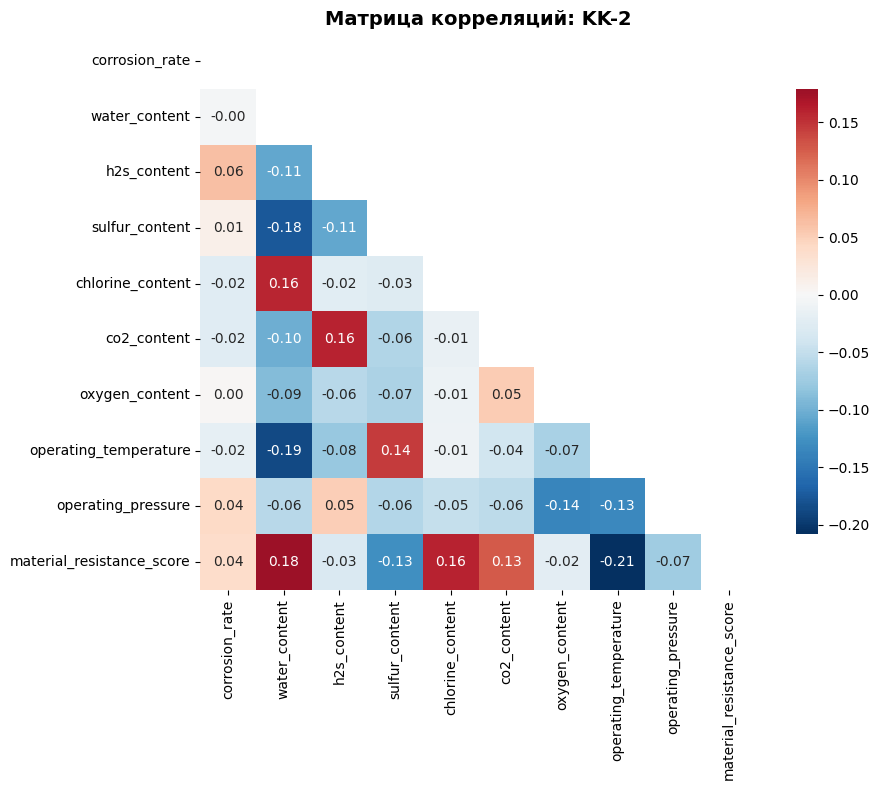

Топ факторов по корреляции с целью:
   1. h2s_content                    : +0.0637
   2. operating_pressure             : +0.0416
   3. material_resistance_score      : +0.0372
   4. sulfur_content                 : +0.0120
   5. oxygen_content                 : +0.0026
   6. water_content                  : -0.0039
   7. operating_temperature          : -0.0188
   8. co2_content                    : -0.0242
   9. chlorine_content               : -0.0243


{'installation': 'KK-2',
 'n_rows': 37814,
 'params_used': ['water_content',
  'h2s_content',
  'sulfur_content',
  'chlorine_content',
  'co2_content',
  'oxygen_content',
  'operating_temperature',
  'operating_pressure',
  'material_resistance_score'],
 'csv_path': '../data/per_installation\\correlations_KK_2.csv',
 'png_path': '../data/per_installation\\correlations_KK_2.png',
 'corr_matrix':                            corrosion_rate  water_content  h2s_content  \
 corrosion_rate                   1.000000      -0.003932     0.063685   
 water_content                   -0.003932       1.000000    -0.108416   
 h2s_content                      0.063685      -0.108416     1.000000   
 sulfur_content                   0.011963      -0.175697    -0.107990   
 chlorine_content                -0.024334       0.158793    -0.023463   
 co2_content                     -0.024195      -0.101425     0.159323   
 oxygen_content                   0.002627      -0.090127    -0.057513   
 operatin

In [15]:
# Параметры запуска: одна установка
installation_name = 'KK-2'  # задайте нужную установку
params = [
    'water_content', 'h2s_content', 'sulfur_content', 'chlorine_content',
    'co2_content', 'oxygen_content', 'operating_temperature', 'operating_pressure','material_resistance_score'
]

result = analyze_installation(df, installation_name, params, target=TARGET, out_dir=DATA_OUT_DIR, plot=True)
result


In [6]:
# Батч: несколько установок и сводный CSV
installations = ['АВТ-5', 'KK-2']  # укажите нужные установки
batch_params = params  # можно задать иной список

rows = []
for inst in installations:
    r = analyze_installation(df, inst, batch_params, target=TARGET, out_dir=DATA_OUT_DIR, plot=False)
    if r is not None:
        top = r['corr_matrix'][TARGET].drop(labels=[TARGET]).sort_values(ascending=False)
        best_param = top.index[0] if len(top) else None
        best_corr = float(top.iloc[0]) if len(top) else None
        rows.append({
            'installation': inst,
            'n_rows': r['n_rows'],
            'best_param': best_param,
            'best_corr': best_corr,
            'csv_path': r['csv_path']
        })

summary = pd.DataFrame(rows)
summary_path = os.path.join(DATA_OUT_DIR, 'summary_per_installation.csv')
summary.to_csv(summary_path, index=False, encoding='utf-8')
print('Сводный файл сохранён:', summary_path)
summary


Топ факторов по корреляции с целью:
   1. operating_temperature          : +0.1527
   2. sulfur_content                 : +0.0241
   3. co2_content                    : -0.0041
   4. h2s_content                    : -0.0107
   5. water_content                  : -0.0143
   6. chlorine_content               : -0.0198
   7. operating_pressure             : -0.0671
   8. oxygen_content                 : +nan
Топ факторов по корреляции с целью:
   1. h2s_content                    : +0.0637
   2. operating_pressure             : +0.0416
   3. sulfur_content                 : +0.0120
   4. oxygen_content                 : +0.0026
   5. water_content                  : -0.0039
   6. operating_temperature          : -0.0188
   7. co2_content                    : -0.0242
   8. chlorine_content               : -0.0243
Сводный файл сохранён: ../data/per_installation\summary_per_installation.csv


,installation,n_rows,best_param,best_corr,csv_path
0,АВТ-5,59667,operating_temperature,0.152675,../data/per_installation\correlations_АВТ_5.csv
1,KK-2,37814,h2s_content,0.063685,../data/per_installation\correlations_KK_2.csv


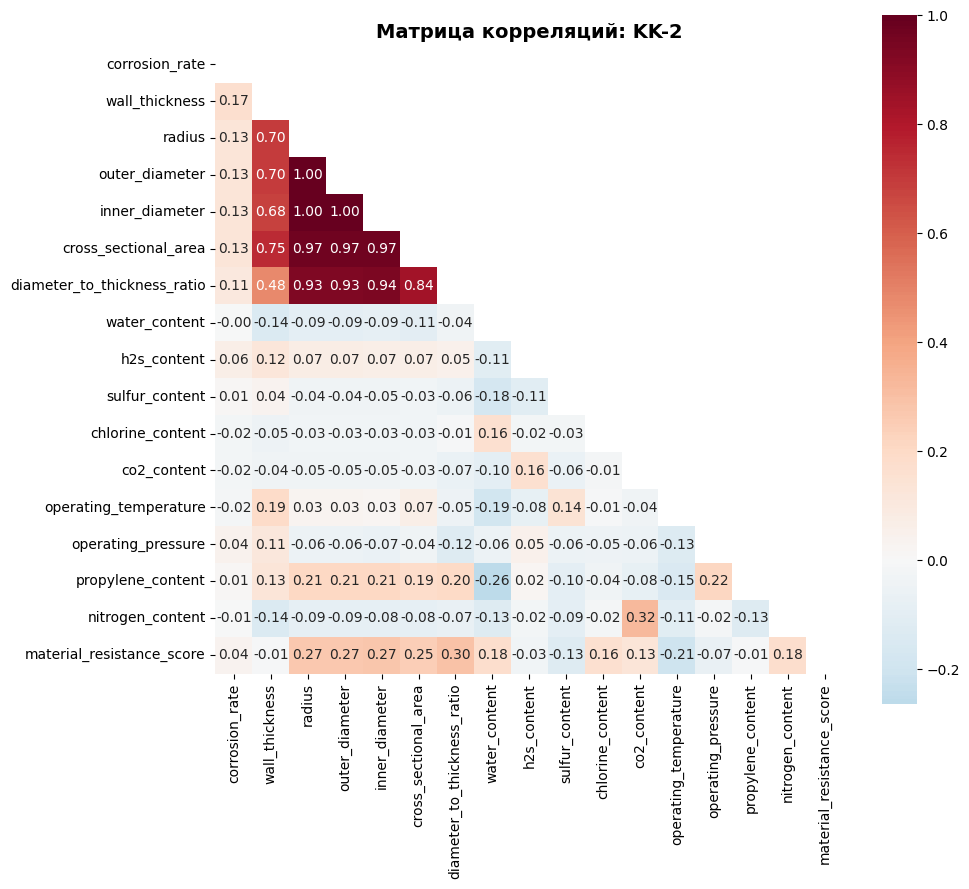

Топ факторов по корреляции с целью:
   1. wall_thickness                 : +0.1711
   2. radius                         : +0.1322
   3. outer_diameter                 : +0.1322
   4. inner_diameter                 : +0.1296
   5. cross_sectional_area           : +0.1272
   6. diameter_to_thickness_ratio    : +0.1075
   7. h2s_content                    : +0.0637
   8. operating_pressure             : +0.0416
   9. material_resistance_score      : +0.0372
  10. propylene_content              : +0.0125
  11. sulfur_content                 : +0.0120
  12. water_content                  : -0.0039
  13. nitrogen_content               : -0.0074
  14. operating_temperature          : -0.0188
  15. co2_content                    : -0.0242
  16. chlorine_content               : -0.0243


{'installation': 'KK-2',
 'n_rows': 37814,
 'params_used': ['wall_thickness',
  'radius',
  'outer_diameter',
  'inner_diameter',
  'cross_sectional_area',
  'diameter_to_thickness_ratio',
  'water_content',
  'h2s_content',
  'sulfur_content',
  'chlorine_content',
  'co2_content',
  'operating_temperature',
  'operating_pressure',
  'propylene_content',
  'nitrogen_content',
  'material_resistance_score'],
 'csv_path': '../data/per_installation\\correlations_KK_2.csv',
 'png_path': '../data/per_installation\\correlations_KK_2.png',
 'corr_matrix':                              corrosion_rate  wall_thickness    radius  \
 corrosion_rate                     1.000000        0.171113  0.132174   
 wall_thickness                     0.171113        1.000000  0.697890   
 radius                             0.132174        0.697890  1.000000   
 outer_diameter                     0.132174        0.697890  1.000000   
 inner_diameter                     0.129605        0.681225  0.999735   
 

In [16]:
# Параметры запуска: одна установка
installation_name = 'KK-2'  # задайте нужную установку
params = ['wall_thickness','radius','outer_diameter','inner_diameter','cross_sectional_area','diameter_to_thickness_ratio',
    'water_content', 'h2s_content', 'sulfur_content', 'chlorine_content',
    'co2_content', 'operating_temperature', 'operating_pressure','propylene_content','nitrogen_content','material_resistance_score'
]
#ТОП-ФАКТОРЫ ВЛИЯНИЯ:
  #Наиболее вероятные УСКОРИТЕЛИ коррозии:
  #  1. operating_temperature     (r = +0.082)
  #  2. sulfur_content            (r = +0.076)
  #  3. sulfur_content    (r = +0.069)
  #  4. h2s_content               (r = +0.017)
  #  5. hydrogen_content          (r = +0.008)

  #Наиболее вероятные ЗАМЕДЛИТЕЛИ коррозии:
    #1. propylene_content         (r = -0.038)
    #2. oxygen_content            (r = -0.027)
    #3. nitrogen_content          (r = -0.023)
    #4. ethylene_content          (r = -0.021)
    #5. water_content             (r = -0.020)
result = analyze_installation(df, installation_name, params, target=TARGET, out_dir=DATA_OUT_DIR, plot=True)
result# ГЕОМЕТРИЧЕСКИЕ (geometry):
# - wall_thickness                    -> толщина стенки (outer_diameter - inner_diameter)
# - radius                            -> outer_diameter / 2.0
# - outer_diameter, inner_diameter    -> диаметры
# - diameter_to_thickness_ratio       -> отношение диаметра к толщине стенки
# - cross_sectional_area              -> площадь поперечного сечения